In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import anndata as ad
import multigrate as mtg
import numpy as np
import gdown

sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.3 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.6.1


In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(Seurat)
library(SeuratDisk)

R[write to console]: Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat

R[write to console]: Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



# Expressions

## Download the data

In [4]:
gdown.download(
    'https://drive.google.com/uc?id=1wA3VBUnYEW2qHPk9WijNTKjV9KriWe8y',
    'kotliarov-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1wA3VBUnYEW2qHPk9WijNTKjV9KriWe8y
To: /Users/alitinet/Desktop/thesis/multigrate/kotliarov-expressions.h5ad
137MB [05:39, 404kB/s]  


'kotliarov-expressions.h5ad'

In [5]:
adata = sc.read('kotliarov-expressions.h5ad')
adata

AnnData object with n_obs × n_vars = 52117 × 3999
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_type_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

## Save raw counts

In [6]:
adata_ = ad.AnnData(adata.layers['count'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_type']
adata_.write('expressions_hvg_counts.h5ad')

## Convert h5ad file with raw counts to a h5Seurat object

In [7]:
%%R
Convert('expressions_hvg_counts.h5ad', 'h5seurat', overwrite=TRUE)

R[write to console]: Warnung:
R[write to console]:  Unknown file type: h5ad

R[write to console]: Warnung:
R[write to console]:  'assay' not set, setting to 'RNA'

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding X as data

R[write to console]: Adding X as counts

R[write to console]: Adding meta.features from var



# Protein

## Download the data

In [8]:
gdown.download(
    'https://drive.google.com/uc?id=112mdDX76LZRL33tBLYhfYRRXOUrLUhw-',
    'kotliarov-protein.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=112mdDX76LZRL33tBLYhfYRRXOUrLUhw-
To: /Users/alitinet/Desktop/thesis/multigrate/kotliarov-protein.h5ad
143MB [06:36, 361kB/s]  


'kotliarov-protein.h5ad'

In [9]:
adata = sc.read('kotliarov-protein.h5ad')
adata

AnnData object with n_obs × n_vars = 52117 × 87
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'batch_colors', 'cell_type_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

## Save raw counts

In [10]:
adata_ = ad.AnnData(adata.layers['count'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_type']
adata_.write('protein_counts.h5ad')

## Convert h5ad file with raw counts to a h5Seurat object

In [11]:
%%R
Convert('protein_counts.h5ad', 'h5seurat', overwrite=TRUE)

R[write to console]: Warnung:
R[write to console]:  Unknown file type: h5ad

R[write to console]: Warnung:
R[write to console]:  'assay' not set, setting to 'RNA'

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding X as data

R[write to console]: Adding X as counts

R[write to console]: Adding meta.features from var



# Run Seurat v4 WNN
Following https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html.

In [12]:
%%R
rna <- LoadH5Seurat("expressions_hvg_counts.h5seurat")
cite <- LoadH5Seurat("protein_counts.h5seurat")

bm <- rna
bm[["ADT"]] <- CreateAssayObject(counts = cite@assays$RNA@counts)

rm(rna)
rm(cite)

print('Preprocessing RNA...')
DefaultAssay(bm) <- "RNA"
bm <- NormalizeData(bm, verbose=FALSE)
VariableFeatures(bm) <- rownames(bm[["RNA"]])
bm <- ScaleData(bm, verbose=FALSE)
bm <- RunPCA(bm, verbose=FALSE)

print('Preprocessing ADT...')
DefaultAssay(bm) <- "ADT"
VariableFeatures(bm) <- rownames(bm[["ADT"]])
bm <- NormalizeData(bm, normalization.method = 'CLR', margin = 2, verbose=FALSE)
bm <- ScaleData(bm, verbose=FALSE)
bm <- RunPCA(bm, reduction.name = "apca", verbose=FALSE)

bm <- FindMultiModalNeighbors(
       bm, reduction.list = list("pca", "apca"), 
       dims.list = list(1:30, 1:18), modality.weight.name = "RNA.weight"
   )

bm <- RunUMAP(bm, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_", verbose=FALSE)
bm <- FindClusters(bm, graph.name = "wsnn", algorithm = 3, resolution = 2, verbose = FALSE)

SaveH5Seurat(bm, 'integrated_kotliarov.h5seurat', overwrite = TRUE)

R[write to console]: Validating h5Seurat file

R[write to console]: Initializing RNA with data

R[write to console]: Adding counts for RNA

R[write to console]: Adding feature-level metadata for RNA

R[write to console]: Adding command information

R[write to console]: Adding cell-level metadata

R[write to console]: Adding miscellaneous information

R[write to console]: Adding tool-specific results

R[write to console]: Validating h5Seurat file

R[write to console]: Initializing RNA with data

R[write to console]: Warnung:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Adding counts for RNA

R[write to console]: Warnung:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Adding feature-level metadata for RNA

R[write to console]: Adding command information

R[write to console]: Adding cell-level metadata

R[write to console]: Adding miscellaneous info

[1] "Preprocessing RNA..."
[1] "Preprocessing ADT..."


R[write to console]: Warnung in irlba(A = t(x = object), nv = npcs, ...)
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.

R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~17s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=35s  


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=10s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~01m 01s       |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02m 05s
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~08s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=13s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Warnung:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session

R[write to console]: Warnung:
R[write to console]:  Overwriting previous file integrated_kotliarov.h5seurat

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: Adding scale.data for RNA

R[write to console]: Adding variable features for RNA

R[write to console]: No feature-level metadata found for RNA

R[write to console]: Adding counts for ADT

R[write to console]: Adding data for ADT

R[write to console]: Adding scale.data for ADT

R[writ

In [13]:
%%R
Convert("integrated_kotliarov.h5Seurat", assay="RNA", "h5ad", overwrite=TRUE)

R[write to console]: Validating h5Seurat file

R[write to console]: Adding scale.data from RNA as X

R[write to console]: Adding data from RNA as raw

R[write to console]: Transfering meta.data to obs

R[write to console]: Adding dimensional reduction information for pca

R[write to console]: Adding feature loadings for pca

R[write to console]: Adding dimensional reduction information for wnn.umap (global)

R[write to console]: Adding wsnn as neighbors



## Visualize the result

In [14]:
integrated = sc.read('integrated_kotliarov.h5ad')
integrated

AnnData object with n_obs × n_vars = 52117 × 3999
    obs: 'cell_type', 'nCount_ADT', 'nFeature_ADT', 'RNA.weight', 'wsnn_res.2', 'seurat_clusters'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_wnn.umap'
    varm: 'PCs'
    obsp: 'distances'

Cell types don't transfer properly due to a SeuratDisk bug so set them manually (https://github.com/mojaveazure/seurat-disk/issues/23).

In [15]:
# check indices
np.sum(adata.obs['cell_type'].index != integrated.obs['cell_type'].index)

0

In [16]:
integrated.obs['cell_type'] = adata.obs['cell_type']

In [17]:
integrated.obs['seurat_clusters'] = integrated.obs['seurat_clusters'].astype('category')

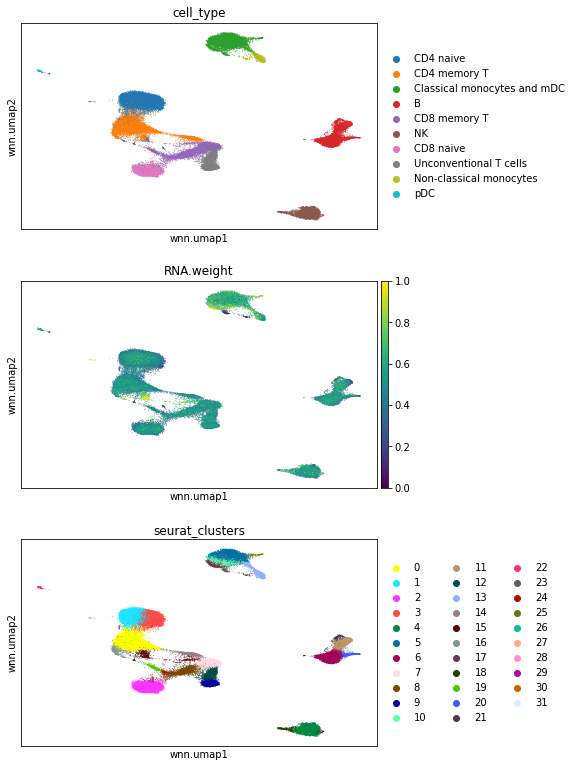

In [18]:
sc.pl.embedding(integrated, basis='wnn.umap', color=['cell_type', 'RNA.weight', 'seurat_clusters'], ncols=1)

## Run metrics

SeuratDisk writes the neighbors graph from the Seurat object to `.uns['neighbors']['distances']`, so change the location to `.uns['neighbors']['connectivities']`.

In [19]:
integrated

AnnData object with n_obs × n_vars = 52117 × 3999
    obs: 'cell_type', 'nCount_ADT', 'nFeature_ADT', 'RNA.weight', 'wsnn_res.2', 'seurat_clusters'
    var: 'features'
    uns: 'neighbors', 'cell_type_colors', 'seurat_clusters_colors'
    obsm: 'X_pca', 'X_wnn.umap'
    varm: 'PCs'
    obsp: 'distances'

In [20]:
integrated.uns['neighbors']['connectivities'] = integrated.uns['neighbors']['distances']

In [25]:
# had to delete due to some seurat to h5ad errors
del integrated.raw

In [26]:
integrated.write('integrated_kotliarov.h5ad')

We only can run graph-based metrics. We don't run `isolated_label_f1` because it requires batch labels, but we treat datasets as batches, i.e. here we have one dataset = one batch, so don't use it.

In [27]:
metrics = mtg.metrics.metrics(
    None, integrated,
    batch_key=None,
    label_key='cell_type',
    method='seurat',
    asw_label=False, 
    asw_batch=False,
    pcr_batch=False, 
    graph_connectivity_batch=True, 
    nmi_=True, 
    ari_=True,
    isolated_label_asw=False, 
    isolated_label_f1=False
)
metrics

Clustering...
Graph connectivity...
NMI cluster/label...
ARI cluster/label...


,score
graph_conn,0.991643
NMI_cluster/label,0.878427
ARI_cluster/label,0.874662


Finally, remove unnecessary files. 

In [28]:
!rm 'kotliarov-expressions.h5ad'
!rm 'kotliarov-protein.h5ad'
!rm 'expressions_hvg_counts.h5ad'
!rm 'protein_counts.h5ad'
!rm 'expressions_hvg_counts.h5seurat'
!rm 'protein_counts.h5seurat'
!rm 'integrated_kotliarov.h5Seurat'

In [29]:
%%R
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/numpy/.dylibs/libopenblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] SeuratDisk_0.0.0.9013 Seurat_3.9.9.9010    

loaded via a namespace (and not attached):
  [1] nlme_3.1-150          matrixStats_0.57.0    bit64_4.0.5          
  [4] RcppAnnoy_0.0.18      RColorBrewer_1.1-2    httr_1.4.2           
  [7] sctransform_0.3.1     R6_2.5.0              irlba_2.3.3          
 [10] rpart_4.1-15          KernSmooth_2.23-18    uwot_0.1.9.9000      
 [13] lazyeval_0.2.2        mgcv_1.8-33           colorspace_2.0-0     
 [16] withr_2.3.0           tidyselect_1.1.0     